참고: https://wikidocs.net/94600  
https://github.com/threegenie/sentiment_project/blob/main/sentiment_project_using_okt.ipynb

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
# import pykospacing
# spacer = pykospacing.Spacing()
from konlpy.tag import Okt
okt = Okt()
from konlp.kma.klt2023 import klt2023
k = klt2023()
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 총 데이터 합치기

In [2]:
# 현재까지 모은 데이터 셋 
df_trn = pd.read_csv('data/train.csv')
df_tst = pd.read_csv('data/test.csv')
df_craw = pd.read_csv('data/Crawling_final.csv')

In [3]:
# 텍스트 파일 열기
with open('data/naver_shopping.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()

# 줄 바꿈 문자 제거 및 각 줄을 공백을 기준으로 분할하여 리스트로 변환
data = [line.strip().split('\t') for line in data]

# 리스트를 데이터프레임으로 변환
df_git = pd.DataFrame(data, columns=['ReviewScore', 'RawText'])

# '평점' 열의 데이터 타입을 정수로 변환
df_git['ReviewScore'] = df_git['ReviewScore'].astype(int)

In [4]:
df_hub = pd.concat([df_trn, df_tst], ignore_index=True)

In [5]:
df_hub

,Index,RawText,ReviewScore,ProductName
0,761636,머리결이 푸석해졌어요. 염색시간은 3시간정도 해야하는데 너무 번거로워요.,5,OO 헤나 파우더 100g 1개
1,761719,천연헤나가 좋다는 건 알지만 흰머리 염색은 너무 번거롭고 오래걸리는 단점이 있네요....,5,OO 헤나 파우더 100g 1개
2,761720,"다크 브라운으로 염색했는데, 발색이 블랙처럼 너무 어둡습니다. 염색 다음날 투명으로...",5,OO 헤나 파우더 100g 1개
3,761743,염색할때 헤나를 계속 사용했는데요 ㅇㅇㅇ는 처음 사용해보네요. 염색은 잘 되는것 같...,4,OO 헤나 파우더 100g 1개
4,761756,"첫번째 주문입니다. 저렴한 가격도 아닌데, 염색이 잘 되지 않습니다. 사용하기도 불...",5,OO 헤나 파우더 100g 1개
...,...,...,...,...
202695,84800,카드할인 받아서 저렴하게 구매한 점이 좋았어요 다만 전원을 좀 오래 눌러야 작동하는...,5,마샬 STANMORE II 해외구매
202696,84801,블랙이랑 화이트 한참고민했는데 화이트가 역시 깔끔하고 선택을 잘한것같아요 ~ 디자인...,5,마샬 STANMORE II 해외구매
202697,84802,블루투스 연결이 기존의 방식과 달라서 겨우 연결했는데 아쉽네요 상품외관상의 문제 없...,4,마샬 STANMORE II 해외구매
202698,84803,화이트라 깨끗해서 마음에 들어요 외관상 마감도 깔끔하고 찍힘없이 아주 잘와서 만족해요,5,마샬 STANMORE II 해외구매


In [6]:
df_craw

,Unnamed: 0,ReviewScore,RawText,ProductName
0,0,5,좋은가격에 좋은질콜라겐을 꾸준히 먹을수있어 늘 만족해요. 식품이니 필수라 생각하고 ...,*분자 *쉬 콜라겐 가루 150g
1,1,5,가성비 좋아서 샀어요 \n개별포장은 휴대해서 먹기 좋지만 이건 무조건 집에서 먹어야...,*분자 *쉬 콜라겐 가루 150g
2,2,5,좋아요 아주 좋아요 ㅎㅎ,*분자 *쉬 콜라겐 가루 150g
3,3,5,배송빨리왔어요 먹기편해요,*분자 *쉬 콜라겐 가루 150g
4,4,5,좋습니다. 합니다^^,*분자 *쉬 콜라겐 가루 150g
...,...,...,...,...
310226,646366,5,매번 주문해요!! 좋아요~!,만년도장 아크릴4푼검정
310227,646367,5,좋아요 매번 주문해서 사용중~~~~~,만년도장 아크릴4푼검정
310228,646368,5,ㅋㅋ 주문을 잘못했어요 한글 두개로 ㅋㅋ 하나는 한자로 해야되는데 졸지에 명인됨 ㅋㅋ,만년도장 아크릴4푼검정
310229,646371,5,도장찍을때마다 인주가 필요없어 넘 편해요,만년도장 아크릴4푼검정


In [7]:
df_git

,ReviewScore,RawText
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


In [8]:
# AI허브의 속성 기반 데이터 22만건: 평점이 1~100점으로 분포
df_hub['ReviewScore'].value_counts()

ReviewScore
5      102130
100     53409
4       17811
80       8428
60       4343
3        4289
70       2265
20       1795
40       1577
10       1533
1        1502
50       1243
90       1024
2         745
30        482
0         124
Name: count, dtype: int64

In [9]:
# 크롤링 데이터: 평점이 1~5점으로 분포
df_craw['ReviewScore'].value_counts()

ReviewScore
5    144265
3     87391
4     49761
2     16233
1     12581
Name: count, dtype: int64

In [10]:
# ReviewScore가 3인 행을 제거
df_craw = df_craw[df_craw['ReviewScore'] != 3]

In [11]:
# 깃허브 데이터: 평점이 1~5점으로 분포
df_git['ReviewScore'].value_counts()

ReviewScore
5    81177
2    63989
1    36048
4    18786
Name: count, dtype: int64

### 클래스 분류

In [12]:
# 1~100점으로 분포된 평점에서 1~50은 0(부정), 51~100은 1(긍정)
df_hub['labels'] = df_hub['ReviewScore'].apply(lambda x: 0 if 0 <= x <= 50 else 1)

# 1~5점으로 분포된 평점에서 1~2은 0(부정), 4~5은 1(긍정)
df_craw['labels'] = df_craw['ReviewScore'].apply(lambda x: 0 if 1 <= x <= 2 else 1)

# 1~5점으로 분포된 평점에서 1~2은 0(부정), 4~5은 1(긍정)
df_git['labels'] = df_git['ReviewScore'].apply(lambda x: 0 if 1 <= x <= 2 else 1)

/var/folders/ph/hz48_2z57cj0x4b76mfndvkc0000gn/T/ipykernel_10898/2103925721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_craw['labels'] = df_craw['ReviewScore'].apply(lambda x: 0 if 1 <= x <= 2 else 1)


In [13]:
# 데이터프레임을 리스트에 담기
dfs = [df_hub, df_craw, df_git]

# 데이터프레임 위아래로 합치기
df = pd.concat(dfs, ignore_index=True)

# 필요없는 열 제거
df.drop(columns=['Index', 'Unnamed: 0'], inplace=True)
df.dropna(subset=['RawText'], inplace=True)

In [14]:
df # 총 데이터셋은 625539건

,RawText,ReviewScore,ProductName,labels
0,머리결이 푸석해졌어요. 염색시간은 3시간정도 해야하는데 너무 번거로워요.,5,OO 헤나 파우더 100g 1개,0
1,천연헤나가 좋다는 건 알지만 흰머리 염색은 너무 번거롭고 오래걸리는 단점이 있네요....,5,OO 헤나 파우더 100g 1개,0
2,"다크 브라운으로 염색했는데, 발색이 블랙처럼 너무 어둡습니다. 염색 다음날 투명으로...",5,OO 헤나 파우더 100g 1개,0
3,염색할때 헤나를 계속 사용했는데요 ㅇㅇㅇ는 처음 사용해보네요. 염색은 잘 되는것 같...,4,OO 헤나 파우더 100g 1개,0
4,"첫번째 주문입니다. 저렴한 가격도 아닌데, 염색이 잘 되지 않습니다. 사용하기도 불...",5,OO 헤나 파우더 100g 1개,0
...,...,...,...,...
625535,장마라그런가!!! 달지않아요,2,NaN,0
625536,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,5,NaN,1
625537,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,5,NaN,1
625538,넘이쁘고 쎄련되보이네요~,5,NaN,1


In [15]:
df['RawText'].nunique(), df['labels'].nunique() # 

(625030, 2)

In [16]:
# RawText 열에서 중복인 내용이 있다면 중복 제거
df.drop_duplicates(subset=['RawText'], inplace=True) # RawText 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(df))

총 샘플의 수 : 625030


In [17]:
# 단어 수 계산 함수
def count_words(text):
    return text.count(' ') + 1

df['Words'] = df['RawText'].apply(count_words)

print(df['Words'].sum())

7333395


In [18]:
df.drop(columns=['Words'], inplace=True)

In [19]:
df.info() # not null

<class 'pandas.core.frame.DataFrame'>
Index: 625030 entries, 0 to 625539
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   RawText      625030 non-null  object
 1   ReviewScore  625030 non-null  int64 
 2   ProductName  425500 non-null  object
 3   labels       625030 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 23.8+ MB


### 레이블의 분포 확인

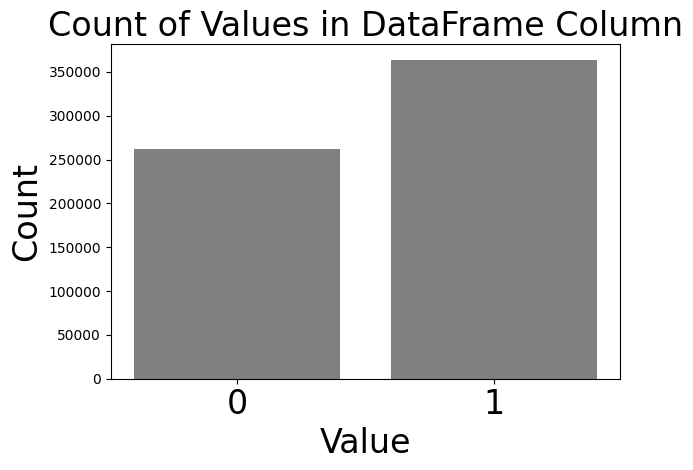

In [32]:
value_counts = df['labels'].value_counts()

plt.bar(value_counts.index, value_counts.values, color='gray')
plt.xticks(value_counts.index, fontsize=24)  # x 축에 0과 1 표시
plt.xlabel('Value', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.title('Count of Values in DataFrame Column', fontsize=24)

plt.tight_layout()  # 레이아웃 조정
plt.savefig('Count of Values in DataFrame Column.png', bbox_inches='tight', dpi=300)
plt.show();

### 데이터 정제

In [34]:
# 한글과 공백을 제외하고 모두 제거
df['RawText'] = df['RawText'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['RawText'].replace('', np.nan, inplace=True)
print(df.isnull().sum())

RawText             0
ReviewScore         0
ProductName    199530
labels              0
dtype: int64


### 토큰화

In [35]:
# Okt 형태소 분석기 실행 시간 측정
start_time = time.time()
df['tokenized_okt'] = df['RawText'].apply(okt.morphs)
okt_time = time.time() - start_time

# Kkma 형태소 분석기 실행 시간 측정
start_time = time.time()
df['tokenized_klt'] = df['RawText'].apply(k.morphs)
k_time = time.time() - start_time

In [36]:
print("Okt 형태소 분석기 실행 시간: ", okt_time)
print("KLT2000 형태소 분석기 실행 시간: ", k_time)

Okt 형태소 분석기 실행 시간:  2064.4929151535034
KLT2000 형태소 분석기 실행 시간:  146.04896903038025


In [37]:
with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.replace('\n','') for x in stopwords] # stopword 파일의 줄바꿈 문자 제거

In [38]:
# 실행 시간이 빨랐던 KLT2000을 활용한 'tokenized' 열에 저장된 리스트에서 불용어를 제거하는 람다 함수를 적용하여 새로운 열 생성
# 더 정확한 결과를 내는 okt를 활용하여 토큰화 진행 
df['tokenized_okt'] = df['tokenized_okt'].apply(lambda x: [item for item in x if item not in stopwords])

In [39]:
df

,RawText,ReviewScore,ProductName,labels,tokenized_okt,tokenized_klt
0,머리결이 푸석해졌어요. 염색시간은 3시간정도 해야하는데 너무 번거로워요.,5,OO 헤나 파우더 100g 1개,0,"[머리, 결, 푸석해졌어요, ., 염색, 3시간, 정도, 해야하는데, 너무, 번거로...","[머리결, 푸석하, 염색시간, 3.0, 시간정도, 해야, 너무, 번거롭]"
1,천연헤나가 좋다는 건 알지만 흰머리 염색은 너무 번거롭고 오래걸리는 단점이 있네요....,5,OO 헤나 파우더 100g 1개,0,"[천, 연, 헤나, 좋다는, 건, 알, 흰, 머리, 염색, 너무, 번거롭고, 오래,...","[천연헤나, 좋, 것, 알, 흰머리, 염색, 너무, 번거롭, 오래, 단점, 있, 머..."
2,"다크 브라운으로 염색했는데, 발색이 블랙처럼 너무 어둡습니다. 염색 다음날 투명으로...",5,OO 헤나 파우더 100g 1개,0,"[다크, 브라운, 염색, 했는데, ,, 발색, 블랙, 처럼, 너무, 어둡습니다, ....","[다크, 브라운, 염색, _, 발색, 블랙, 너무, 어둡, 염색, 다음날, 투명, ..."
3,염색할때 헤나를 계속 사용했는데요 ㅇㅇㅇ는 처음 사용해보네요. 염색은 잘 되는것 같...,4,OO 헤나 파우더 100g 1개,0,"[염색, 할, 헤나, 계속, 사용, 했는데요, ㅇㅇㅇ, 처음, 사용, 해보네요, ....","[염색할때, 헤나, 계속, 사용, _, _, _, 늘, 처음, 사용하, 염색, 잘,..."
4,"첫번째 주문입니다. 저렴한 가격도 아닌데, 염색이 잘 되지 않습니다. 사용하기도 불...",5,OO 헤나 파우더 100g 1개,0,"[첫, 번째, 주문, 입니다, ., 저렴한, 가격, 아닌데, ,, 염색, 잘, 되지...","[첫번째, 주문, 저렴, 가격, 아니, _, 염색, 잘, 되, 않, 사용, 불편, ..."
...,...,...,...,...,...,...
625535,장마라그런가!!! 달지않아요,2,NaN,0,"[장마, 라, 런가, !!!, 달, 지, 않아요]","[디자인, 특히, 마음에들어, 토끼, 그림, 넘, 이쁘, 생각, 무게, 무겁, 놀라..."
625536,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...,5,NaN,1,"[다이슨, 케이스, 구매, 다이슨, 슈퍼소닉, 드라이기, 케이스, 구매, 가격, 괜...","[흡수력, 너무, 약해, 사포, 여러번하, 흡수, 되, 않, 새로, 사려]"
625537,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요,5,NaN,1,"[로드샾, 사는것보다, 세배, 저렴하네요, ㅜㅜ, 자주, 용할께요]","[재구매, _, _, 자주, 애용하고있습니]"
625538,넘이쁘고 쎄련되보이네요~,5,NaN,1,"[넘, 이쁘고, 쎄련, 되, 보이네요, ~]","[같은층, 선반지지, 높이, 다르, 덜컹거리, 모서리, 날카롭긴하, 싼맛, 사서, 쓰]"


okt의 정확도가 더 높다고 판단되어 klt -> okt로 수정

In [40]:
# 지정된 피처를 삭제합니다.
df.drop(columns='tokenized_klt', inplace=True)

# 피처 이름을 변경합니다.
df.rename(columns={'tokenized_okt': 'tokenized'}, inplace=True)

In [41]:
df.to_csv('data/preprocessed_total_data.csv', index=False) # 혹시 몰라서 저장

---

### 단어와 길이 분포 확인하기

In [42]:
# 긍정, 부정 각 단어의 빈도수 계산 
negative_words = np.hstack(df[df.labels == 0]['tokenized'].values)
positive_words = np.hstack(df[df.labels == 1]['tokenized'].values)

In [43]:
# 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('.', 307919), ('잘', 60344), ('너무', 56707), ('사용', 53680), ('제품', 49441), ('..', 39835), ('요', 39351), ('안', 36345), ('가격', 35782), ('구매', 34129), ('배송', 32807), ('좋아요', 30705), ('다', 26866), ('좋습니다', 25032), ('한', 24887), ('~', 24804), ('해서', 24783), ('향', 24696), ('입니다', 24267), ('했는데', 22488)]


In [44]:
# 긍정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('.', 173337), ('잘', 81591), ('좋아요', 80798), ('\n', 55184), ('너무', 51562), ('사용', 48780), ('~', 47657), ('배송', 44082), ('구매', 41309), ('요', 34901), ('가격', 31666), ('!', 31202), ('제품', 26063), ('같아요', 25649), ('입니다', 24691), ('다', 22215), ('주문', 21280), (',', 21198), ('한', 20387), ('더', 20146)]


긍정 리뷰의 평균 길이 : 13.42019147659394
부정 리뷰의 평균 길이 : 20.595534636367805


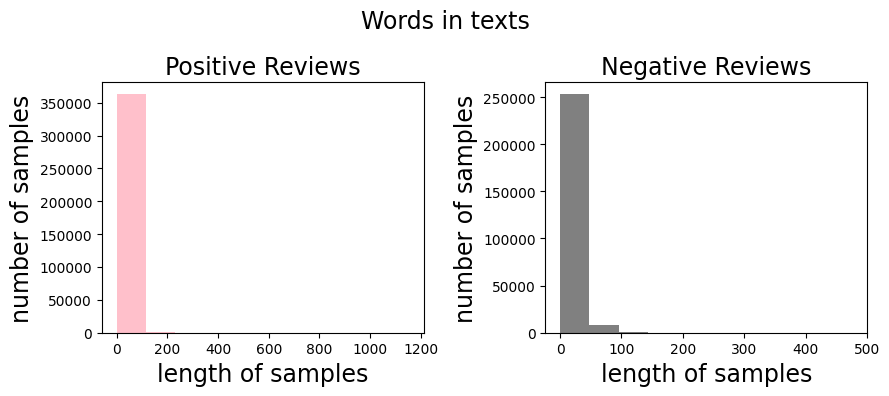

In [60]:
# 두 가지 경우에 대해서 각각 길이 분포를 확인
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
text_len = df[df['labels']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='pink')
ax1.set_title('Positive Reviews', fontsize=17)
ax1.set_xlabel('length of samples', fontsize=17)
ax1.set_ylabel('number of samples', fontsize=17)
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = df[df['labels']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='gray')
ax2.set_title('Negative Reviews', fontsize=17)
fig.suptitle('Words in texts', fontsize=17)
ax2.set_xlabel('length of samples', fontsize=17)
ax2.set_ylabel('number of samples', fontsize=17)
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

plt.tight_layout()  # 레이아웃 조정
plt.savefig('Words in texts.png', bbox_inches='tight', dpi=300)
plt.show();

긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같다.

### 정수 인코딩

In [46]:
# 훈련 데이터와 테스트 데이터 분리하기
train_data, test_data = train_test_split(df, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 468772
테스트용 리뷰의 개수 : 156258


In [47]:
X_train = train_data['tokenized'].values
y_train = train_data['labels'].values
X_test= test_data['tokenized'].values
y_test = test_data['labels'].values

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [49]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 168268
등장 빈도가 1번 이하인 희귀 단어의 수: 89721
단어 집합에서 희귀 단어의 비율: 53.320298571326695
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.1653349196535725


In [50]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 78549


In [51]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [52]:
print(X_train[:3])

[[26, 3306, 2, 630, 1004], [3092, 37, 3941, 18, 71, 1156, 539, 6981, 1679, 9, 2, 280, 41, 19, 904, 1668, 8, 33, 290, 1759, 2, 26, 272, 357, 27, 2, 97, 25, 6, 2382, 37, 24, 2], [124, 10840, 881, 4061, 870, 635, 2662, 6, 8634, 17]]


In [53]:
print(X_test[:3])

[[96, 2904, 5, 50, 3397], [1], [481, 56, 2208, 37, 68, 69, 170, 319, 10705, 109, 2196, 265, 5214, 140, 39, 240, 47, 70]]


### 패딩

리뷰의 최대 길이: 1154
리뷰의 평균 길이: 16.42410382872697


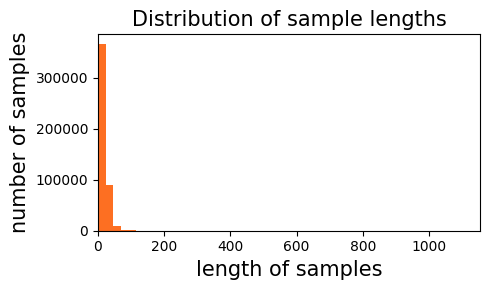

In [61]:
# 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포
max_length = max(len(review) for review in X_train)
print('리뷰의 최대 길이:', max_length)
print('리뷰의 평균 길이:', sum(map(len, X_train))/len(X_train))

plt.figure(figsize=(5, 3))  # 그래프 크기 조정
plt.hist([len(review) for review in X_train], bins=50, color='#FD6F22')
plt.xlabel('length of samples', fontsize = 15)
plt.ylabel('number of samples', fontsize = 15)
plt.title('Distribution of sample lengths', fontsize = 15)
plt.xlim(0, max_length)  # 가로 축 범위 조정

plt.tight_layout()  # 레이아웃 조정
plt.savefig('Distribution of sample lengths.png', bbox_inches='tight', dpi=300)
plt.show();

리뷰의 최대 길이 (제거 후): 518
리뷰의 평균 길이 (제거 후): 16.416253703865674


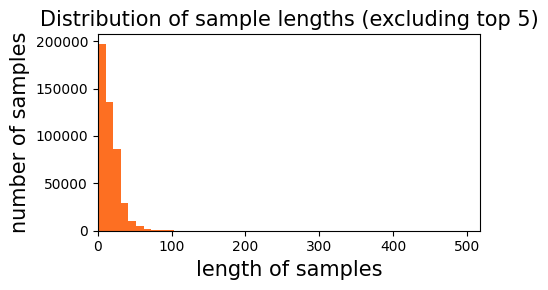

In [57]:
# 가장 긴 리뷰의 길이를 두 번 찾습니다.
max_lengths = sorted([len(review) for review in X_train], reverse=True)[:5]

# 최대값을 제외한 리뷰 길이들로 이루어진 리스트를 만듭니다.
filtered_lengths = [len(review) for review in X_train if len(review) not in max_lengths]

print('리뷰의 최대 길이 (제거 후):', max(filtered_lengths))
print('리뷰의 평균 길이 (제거 후):', sum(filtered_lengths) / len(filtered_lengths))

plt.figure(figsize=(5, 3))
plt.hist(filtered_lengths, bins=50, color='#FD6F22')
plt.xlabel('length of samples', fontsize = 15)
plt.ylabel('number of samples', fontsize = 15)
plt.title('Distribution of sample lengths (excluding top 5)', fontsize = 15)
plt.xlim(0, max(filtered_lengths))
plt.tight_layout()  # 레이아웃 조정
plt.savefig('Negative Reviews.png', bbox_inches='tight', dpi=300)
plt.show();

전체적으로는 100이하의 길이를 가지는 것으로 보인다.

In [365]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [366]:
# 몇 개의 샘플들을 온전히 보전할 수 있는지 확인
max_len = 350
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 350 이하인 샘플의 비율: 99.99765344346505


훈련용 리뷰의 99.99%가 350이하의 길이를 가진다. 훈련용 리뷰를 길이 350으로 패딩한다.

In [367]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)